# Predicción de la tasa de anillamiento de aves
**Autores:** DANIELLE MAREE MCKENNEY & MARIA JOSÉ CASTRO PÉREZ   &nbsp;&nbsp;&nbsp; **Última modificación:** 14/01/2024

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.spatial import distance_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1.Lectura del dataset

### 1.1 Definición de funciones auxiliares

In [2]:
def cleanRawData(rawData, relevantColumns):
    # returns a dataframe with only the relevent columns and with invalid location entries removed
    df = rawData.filter(items=relevantColumns)
    df = df[(df['decimalLatitude'] != 0) & (df['decimalLongitude'] != 0)]
    return datos

def fillInCounts0(data, dateCombination):
    # Fill in count=0 in the grouped summary
    # Get all unique combinations of the date combination
    existing_combinations = data[dateCombination].drop_duplicates()

    # Create a DataFrame with all unique species
    all_species_combinations = pd.DataFrame({'species': data['species'].unique()})

    # Cross join (cartesian product) to get all combinations of 'species', 'eventDate', and 'locality'
    all_combinations = pd.merge(existing_combinations.assign(key=1), all_species_combinations.assign(key=1), on='key').drop('key', axis=1)

    # Merge with the original DataFrame to get counts
    on = dateCombination.append('species')
    result_datos = pd.merge(all_combinations, data, on=on, how='left').fillna(0)
    return result_df

In [3]:
## 1. LECTURA DEL DATASET
DATOS = pd.read_csv('./DATASET.csv', sep="\t", on_bad_lines="warn")
relevantColumns = ['species','locality','decimalLatitude', 'decimalLongitude', 'eventDate', 'stateProvince']

df = cleanRawData(DATOS, relevantColumns)

In [4]:
df

,species,locality,decimalLatitude,decimalLongitude,eventDate,stateProvince
0,Turdus merula,Zona de huertos,41.80000,-2.78333,1980-09-11T00:00:00,Soria
1,Turdus merula,Sant esteve de la sarga,42.06667,0.76667,1983-09-30T00:00:00,Lleida
2,Turdus merula,Sagunto,39.66667,-0.28333,1980-07-12T00:00:00,Valencia
3,Turdus merula,Viernoles,43.31667,-6.06667,1981-03-08T00:00:00,Cantabria
4,Turdus merula,Finca cienfuegos,40.61667,-2.98333,1985-03-31T00:00:00,Guadalajara
...,...,...,...,...,...,...
753574,Phylloscopus collybita,Azuqueca de henares,40.55000,-3.25000,2013-12-27T00:00:00,Guadalajara
753575,Phylloscopus collybita,Reserva del tancat de la pipa,39.35806,-0.36333,2015-01-26T00:00:00,Valencia
753576,Phylloscopus collybita,Tancat de milia,39.31389,-0.36444,2018-12-01T00:00:00,Valencia
753577,Phylloscopus collybita,Navas del rey,40.38333,-4.26667,2019-02-23T00:00:00,Madrid


### 1.2 Agrupaciones por semana, mes, quarter y año

In [15]:

# Group by 'species', 'eventDate', and 'stateProvince' and count the rows in each group
grouped_eventDate_df = df.groupby(['species', 'eventDate', 'locality']).size().reset_index(name='count')
# Fill in count=0 on days where a locality was visited but no entry was made for that species
grouped_eventDate_df = fillInCounts0(grouped_eventDate_df, ['eventDate', 'locality'])

grouped_eventDate_df['eventDate'] = pd.to_datetime(grouped_eventDate_df['eventDate'])

grouped_eventDate_df['weekOfYear'] = grouped_eventDate_df['eventDate'].dt.isocalendar().week 
grouped_eventDate_df['month'] = grouped_eventDate_df['eventDate'].dt.month
grouped_eventDate_df['quarter'] = grouped_eventDate_df['eventDate'].dt.to_period('Q')
grouped_eventDate_df['year'] = grouped_eventDate_df['eventDate'].dt.year

grouped_weekOfYear_df = grouped_eventDate_df.groupby(['species', 'weekOfYear', 'year', 'locality']).sum('count').reset_index()
grouped_weekOfYear_df = grouped_weekOfYear_df.filter(items=['species', 'weekOfYear', 'year', 'locality', 'count', 'stateProvince'])

grouped_month_df = grouped_eventDate_df.groupby(['species', 'month', 'year', 'locality']).sum('count').reset_index()
grouped_month_df = grouped_month_df.filter(items=['species', 'month', 'year', 'locality', 'count', 'stateProvince'])

grouped_quarter_df = grouped_eventDate_df.groupby(['species', 'quarter', 'locality']).sum('count').reset_index()
grouped_quarter_df = grouped_quarter_df.filter(items=['species', 'quarter', 'year', 'locality', 'count', 'stateProvince'])

grouped_year_df = grouped_eventDate_df.groupby(['species', 'year', 'locality']).sum('count').reset_index()
grouped_year_df = grouped_year_df.filter(items=['species', 'year', 'locality', 'count','stateProvince'])


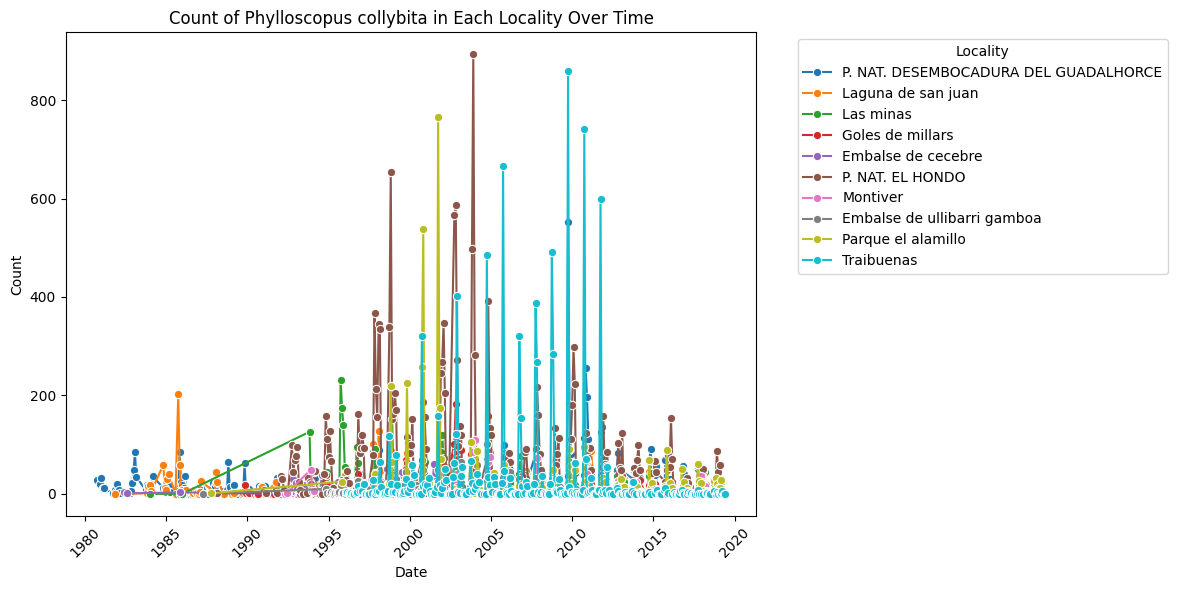

Laguna de san juan


In [39]:
grouped_month_df

# species_to_visualize = 'Merops apiaster'
species_to_visualize = "Phylloscopus collybita"
species_data_month = grouped_month_df[grouped_month_df['species'] == species_to_visualize]

locality_counts = species_data_month['locality'].value_counts()

# Get the 10 most common localities
top_20_localities = locality_counts.nlargest(10)

# List the names and counts of the top 20 localities
grouped_month_df_top_20_loc = species_data_month[species_data_month['locality'].isin(top_20_localities.index)]
df = grouped_month_df_top_20_loc.copy()
df['date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))

# Assuming 'locality' is the location you want to visualize
# You can choose a specific species if you have multiple species in the dataset

# Filter data for the selected species
species_data = df[df['species'] == species_to_visualize]

# Plot the count in each location over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='count', hue='locality', data=species_data, marker='o')
plt.title(f'Count of {species_to_visualize} in Each Locality Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Locality', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# for cld in top_20_localities.index:
#     chosen_locality_data = species_data[species_data['locality'] == cld]

#     # Plot the count for the chosen locality
#     plt.figure(figsize=(12, 6))
#     sns.lineplot(x='date', y='count', data=chosen_locality_data, marker='o')
#     plt.title(f'Count of {species_to_visualize} in {chosen_locality_data["locality"].iloc[0]} Over Time')
#     plt.xlabel('Date')
#     plt.ylabel('Count')
#     plt.xticks(rotation=45)

#     plt.tight_layout()
#     plt.show()
print(top_20_localities.idxmax())

### 2.1. Conteo de especies por año

## 3. Phylloscopus collybita : Mosquitero

### 3.1. Conteo de Mosquitero por año

/var/folders/dx/9xjdddhn30jfw1p92r0hl5gh0000gn/T/ipykernel_55459/2086194073.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))


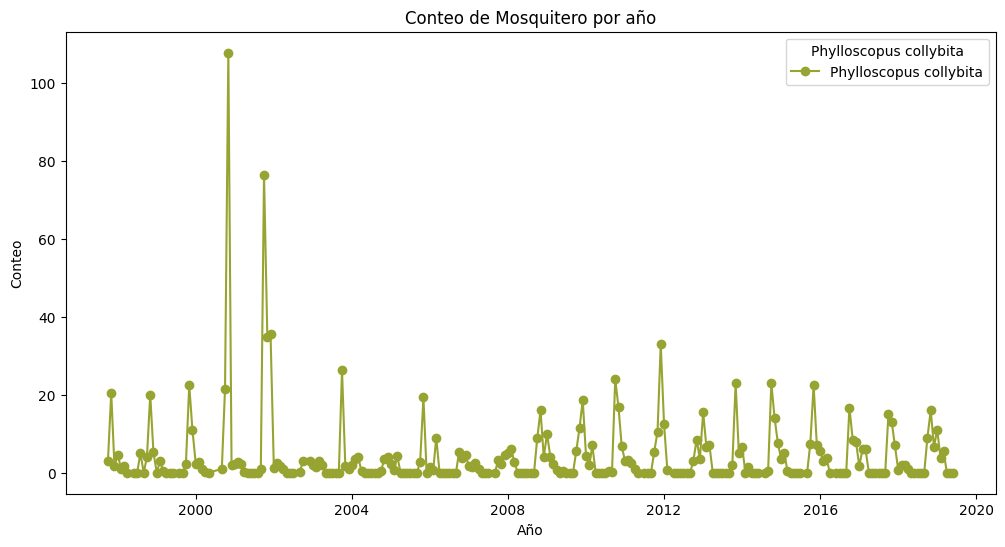

In [87]:
especie = 'Phylloscopus collybita'
nombre_comun = 'Mosquitero'
# locality = "Traibuenas"
locality = "Parque el alamillo"
grouped_month_df_mean = grouped_eventDate_df.groupby(['species', 'month', 'year', 'locality']).mean('count').reset_index()
grouped_month_df_mean = grouped_month_df_mean.filter(items=['species', 'month', 'year', 'locality', 'count'])

df_filtrado = grouped_month_df_mean[(grouped_month_df['species'] == especie) & (grouped_month_df_mean['locality'] == locality)]
df_filtrado['date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
df_filtrado = df_filtrado.sort_values(by='date')
df_filtrado = df_filtrado[df_filtrado['date'] > '1997-01-01']


### 3.1. Conteo de ave por año
plt.figure(figsize=(12, 6))
plt.plot(df_filtrado['date'], df_filtrado['count'], marker='o', color=especies_a_colores[especie], label=especie)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de ' + nombre_comun + ' por año')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

# 7.Predicción series temporales

In [64]:
grouped_month_df_mean

,species,month,year,locality,count
0,Merops apiaster,1,1960,Burjasot,0.000000
1,Merops apiaster,1,1960,Chipiona,0.000000
2,Merops apiaster,1,1960,Garriguella,0.000000
3,Merops apiaster,1,1960,Zumaya,0.000000
4,Merops apiaster,1,1962,La cenia,0.000000
...,...,...,...,...,...
291711,Turdus philomelos,12,2018,Ullal de baldovi,0.000000
291712,Turdus philomelos,12,2018,Valdelafuente,0.111111
291713,Turdus philomelos,12,2018,Valencia,0.333333
291714,Turdus philomelos,12,2018,Villacaparra,0.250000


In [65]:
# Librería estándar
import os
import datetime

# Análisis numérico y datasets
import numpy as np
from scipy import stats

# Análisis y preprocesado de series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Librerías de machine learning
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import tensorflow as tf  #pip install --upgrade pip   #pip install tensorflow

# Módulos locales, extraidos de la documentación de TensorFlow
from window_generator import WindowGenerator

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
def muestra_informacion_lotes(dataset):
    print('Número de lotes:', len(dataset))
    lotes = [(inputs, targets) for inputs, targets in dataset]
    for i, (inputs, targets) in enumerate(lotes[:10]):
        print('Lote {} => forma entradas: {}, forma salidas: {}'.format(i+1, inputs.shape, targets.shape))
    ultimo_lote = lotes[-1]
    print('Último lote ({}) forma entradas: {}, forma salidas: {}'.format(len(dataset), ultimo_lote[0].shape, ultimo_lote[0].shape))


In [147]:
especie = 'Phylloscopus collybita'
datos = grouped_month_df_mean[(grouped_month_df['species'] == especie) & (grouped_month_df_mean['locality'] == locality)]
datos['date'] = pd.to_datetime(datos[['year', 'month']].assign(DAY=1))
datos = datos.sort_values(by='date')
datos = datos[datos['date'] > '1997-01-01']
datos = datos.drop('species', axis=1)
datos = datos.drop('locality', axis=1)
datos = datos.set_index('date')

# Define the month frequency
start_date = datos.index.min()
end_date = datos.index.max()
new_dates = pd.date_range(start=start_date, end=end_date, freq='MS')
new_datos = pd.DataFrame(index=new_dates)
datos = new_datos.merge(datos, how='left', left_index=True, right_index=True)

# Interpolate by mean on missing data
datos['count'].interpolate(method='linear', limit_direction='both', inplace=True)
datos

/var/folders/dx/9xjdddhn30jfw1p92r0hl5gh0000gn/T/ipykernel_55459/537418691.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos['date'] = pd.to_datetime(datos[['year', 'month']].assign(DAY=1))


,month,year,count
1997-10-01,10.0,1997.0,3.000000
1997-11-01,11.0,1997.0,20.500000
1997-12-01,12.0,1997.0,1.714286
1998-01-01,1.0,1998.0,4.666667
1998-02-01,2.0,1998.0,1.000000
...,...,...,...
2019-02-01,2.0,2019.0,3.666667
2019-03-01,3.0,2019.0,5.600000
2019-04-01,4.0,2019.0,0.000000
2019-05-01,5.0,2019.0,0.000000


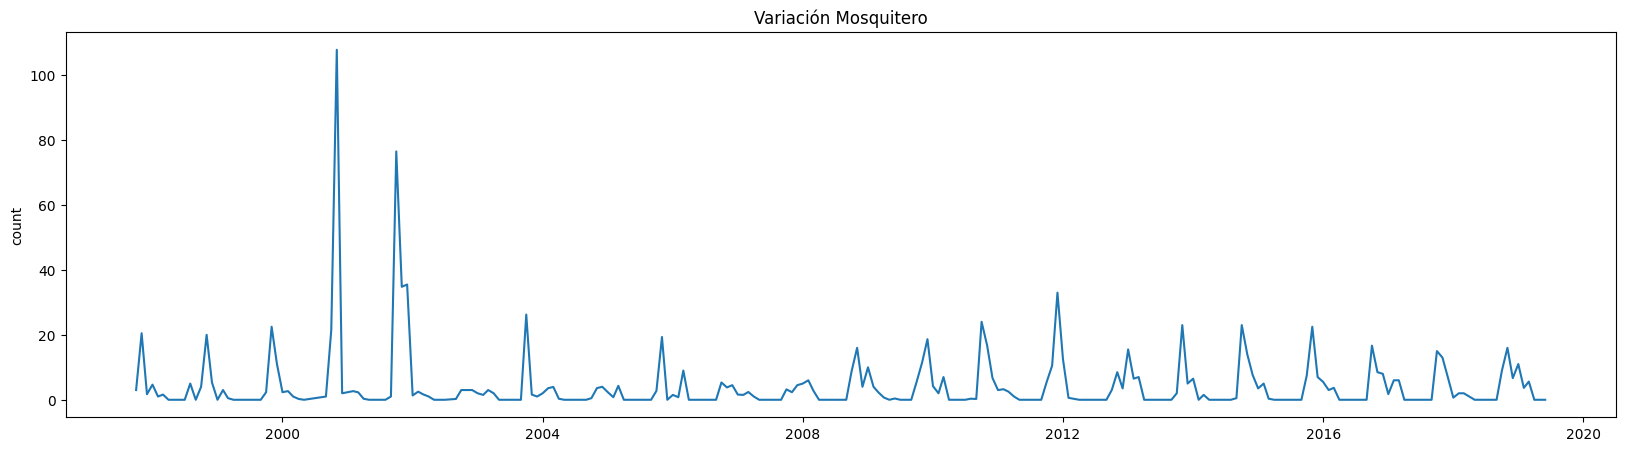

In [148]:
def trazar(datos, rotacion=0, desde=None, hasta=None, figsize=(20, 5), title=''):
    plt.figure(figsize=figsize)
    if desde is None:
        desde = datos.index.min()
    else:
        desde = pd.to_datetime(desde, format='%d/%m/%Y')
    if hasta is None:
        hasta = datos.index.max()
    else:
        hasta = pd.to_datetime(hasta, format='%d/%m/%Y')
    
    datos=datos[(datos.index>=desde)&(datos.index<=hasta)]
    sns.lineplot(data=datos)
    plt.xticks(rotation=rotacion)
    plt.title(title)
    plt.show()
    
trazar(datos['count'], title="Variación Mosquitero")

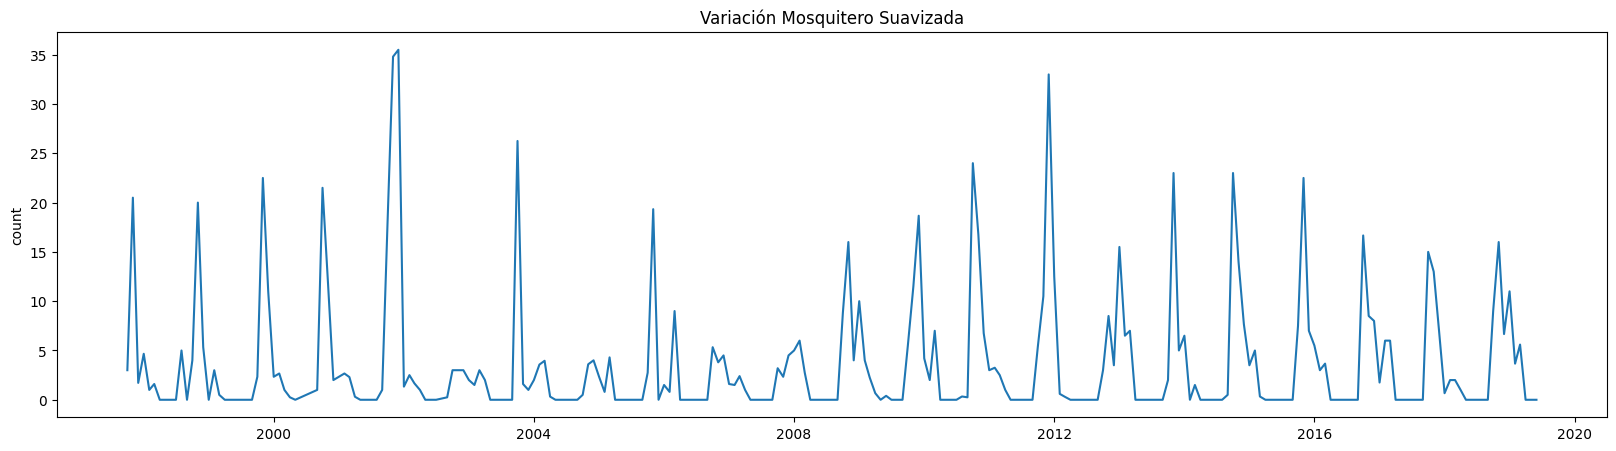

In [176]:
# Smooth the data; interpolate on data whose zscore is >= umbral_zscore
def suavizar_outliers(datos, umbral_zscore=3):
    df = pd.DataFrame({'serie':datos})   
    df['zscore'] = stats.zscore(datos).abs()
    df.loc[df['zscore'] >= umbral_zscore, 'serie'] = np.nan
    df['serie'] = df['serie'].interpolate(method='linear')  # Interpolate missing values
    return df['serie']

datos_smoothed= datos.copy()
datos_smoothed['count'] = suavizar_outliers(datos['count'],4)
trazar(datos_smoothed['count'], title="Variación Mosquitero Suavizada")


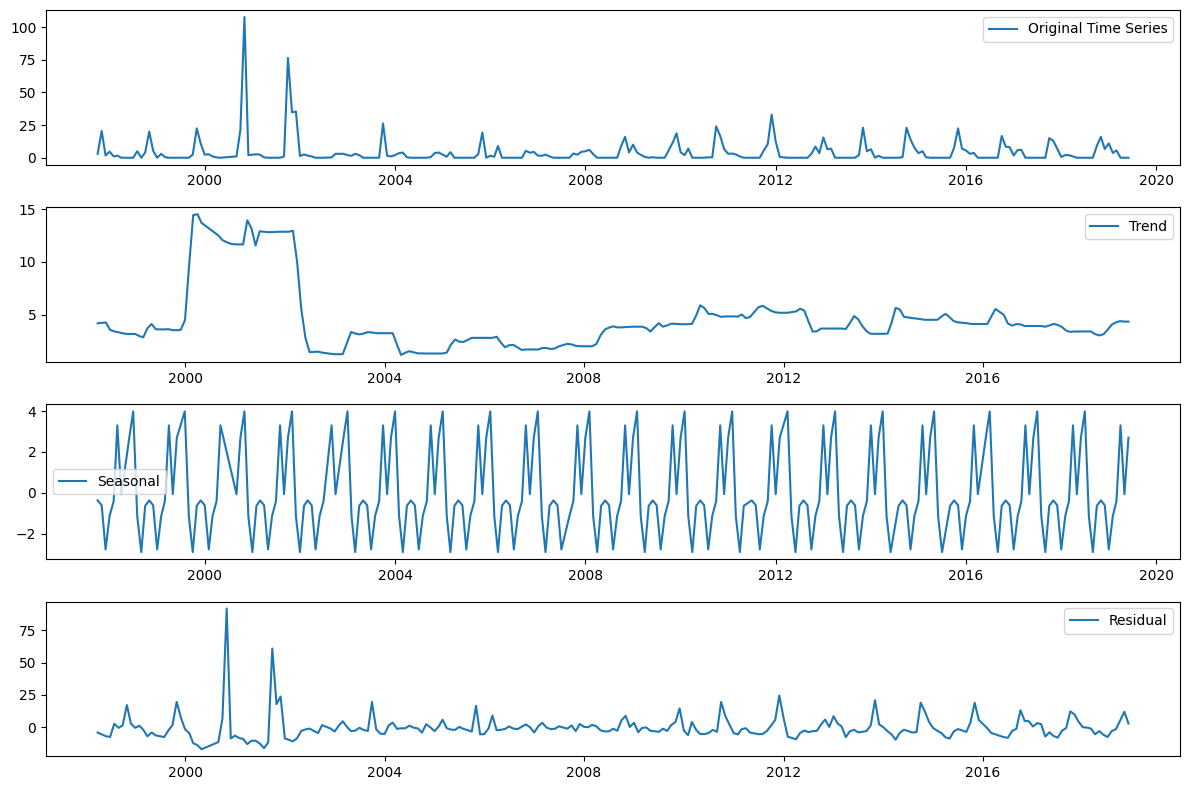

In [108]:
from statsmodels.tsa.seasonal import seasonal_decompose

# # Perform seasonal decomposition
result = seasonal_decompose(datos['count'], model='additive', period=12)

# Plot the original time series, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(datos['count'], label='Original Time Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


In [112]:
# Proporciones: 70%-20%-10%
tamaño = len(datos)
train = datos[0:int(tamaño*0.7)]
val = datos[int(tamaño*0.7):int(tamaño*0.9)]
test = datos[int(tamaño*0.9):]

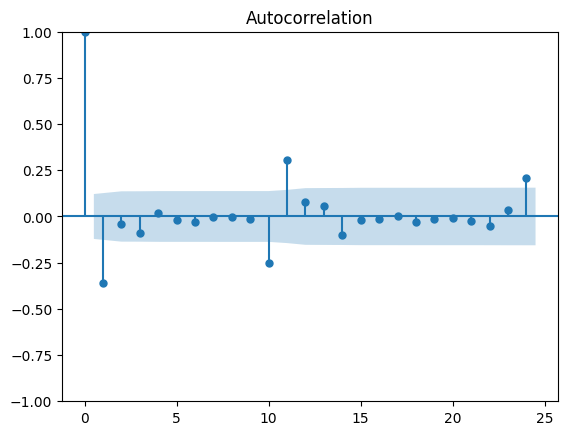

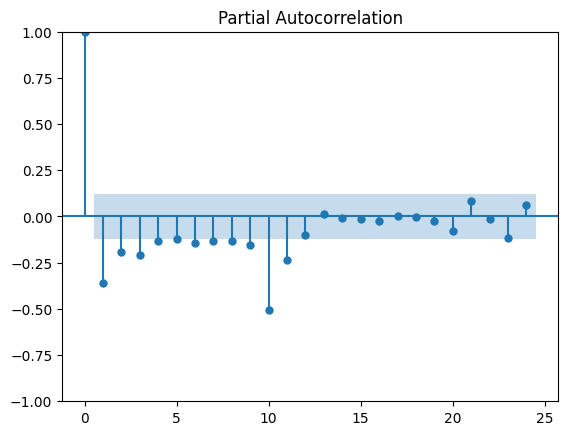

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57238D+00    |proj g|=  1.14391D-01


 This problem is unconstrained.



At iterate    5    f=  3.46986D+00    |proj g|=  3.96697D-02

At iterate   10    f=  3.45384D+00    |proj g|=  7.98510D-03

At iterate   15    f=  3.45214D+00    |proj g|=  4.17208D-03

At iterate   20    f=  3.44960D+00    |proj g|=  1.79225D-02

At iterate   25    f=  3.44833D+00    |proj g|=  3.36207D-03

At iterate   30    f=  3.44789D+00    |proj g|=  2.67735D-03

At iterate   35    f=  3.44776D+00    |proj g|=  9.73230D-04

At iterate   40    f=  3.44774D+00    |proj g|=  9.09247D-05

At iterate   45    f=  3.44774D+00    |proj g|=  1.39261D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     57   

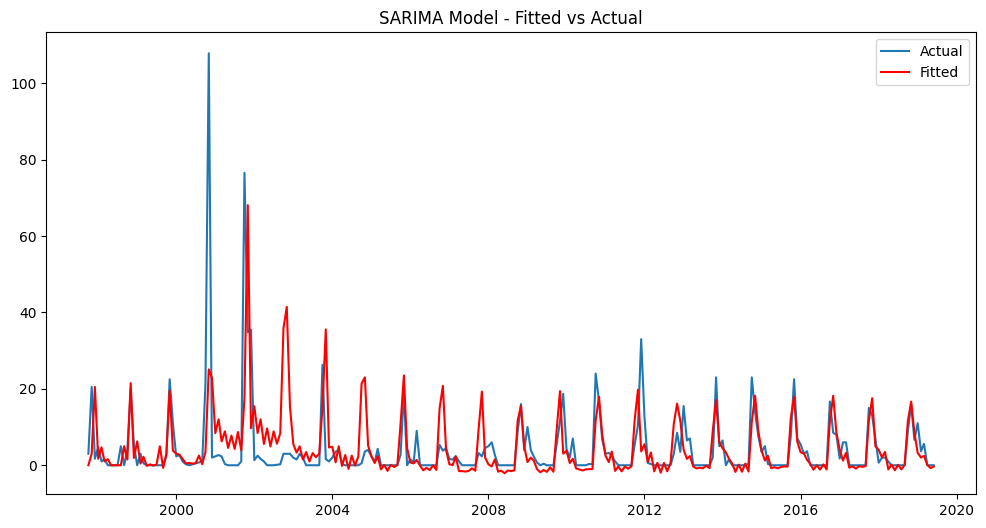

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Determine the order of differencing
diff = datos['count'].diff().dropna()

# Plot ACF and PACF to help determine the seasonal order
plot_acf(diff, lags=24)
plot_pacf(diff, lags=24)
plt.show()

# Fit SARIMA model
# try p/P = 10, try 2

order = (2, 1, 2)  # Replaced with appropriate values based on ACF and PACF analysis
seasonal_order = (2, 1, 2, 12)  # Assuming a yearly seasonality
sarima_model = SARIMAX(datos['count'], order=order, seasonal_order=seasonal_order)
sarima_results = sarima_model.fit()

# Plot predicted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(datos['count'], label='Actual')
plt.plot(sarima_results.fittedvalues, label='Fitted', color='red')
plt.title('SARIMA Model - Fitted vs Actual')
plt.legend()
plt.show()


MAE: 1.55
MSE: 6.25
RMSE: 2.50


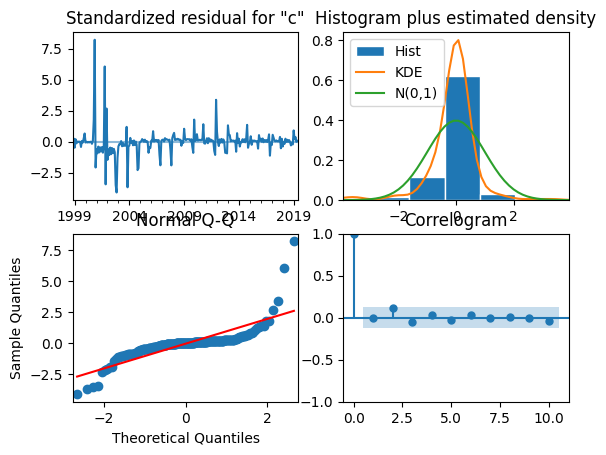

In [151]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error, mean_squared_error

predictions = sarima_results.get_prediction(start='2018-05-01', end='2019-06-01')  # Replace with appropriate date range
actual = datos['count']['2018-05-01':'2019-06-01']  # Replace with appropriate date range

mae = mean_absolute_error(actual, predictions.predicted_mean)
mse = mean_squared_error(actual, predictions.predicted_mean)
rmse = np.sqrt(mse)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')


# Assuming sarima_model is your SARIMA model
# tscv = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits as needed
# cv_scores = []

# for train_index, test_index in tscv.split(datos['count']):
#     train_data = datos['count'].iloc[train_index]
#     test_data = datos['count'].iloc[test_index]

#     sarima_cv_model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
#     sarima_cv_results = sarima_cv_model.fit()

#     predictions_cv = sarima_cv_results.get_forecast(steps=len(test_data)).predicted_mean
#     mse_cv = mean_squared_error(test_data, predictions_cv)
#     cv_scores.append(mse_cv)

# average_cv_score = np.mean(cv_scores)
# print(f'Average CV MSE: {average_cv_score:.2f}')


sarima_results.plot_diagnostics()
plt.show()


In [126]:
datos

,month,year,count
date,,,
1997-10-01,10,1997,3.000000
1997-11-01,11,1997,20.500000
1997-12-01,12,1997,1.714286
1998-01-01,1,1998,4.666667
1998-02-01,2,1998,1.000000
...,...,...,...
2019-02-01,2,2019,3.666667
2019-03-01,3,2019,5.600000
2019-04-01,4,2019,0.000000


In [113]:
#generacion ventana simple
wg_7_1 = WindowGenerator(train_df=train,
                         val_df=val,
                         test_df=test,
                         input_width=12,
                         label_width=1,
                         shift=1,
                         label_columns=['count'])

In [114]:
wg_7_1
muestra_informacion_lotes(wg_7_1.train)

Número de lotes: 6
Lote 1 => forma entradas: (32, 12, 3), forma salidas: (32, 1, 1)
Lote 2 => forma entradas: (32, 12, 3), forma salidas: (32, 1, 1)
Lote 3 => forma entradas: (32, 12, 3), forma salidas: (32, 1, 1)
Lote 4 => forma entradas: (32, 12, 3), forma salidas: (32, 1, 1)
Lote 5 => forma entradas: (32, 12, 3), forma salidas: (32, 1, 1)
Lote 6 => forma entradas: (1, 12, 3), forma salidas: (1, 1, 1)
Último lote (6) forma entradas: (1, 12, 3), forma salidas: (1, 12, 3)


In [115]:
def compile_and_fit(model, window, patience=2, max_epochs=50):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=max_epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [116]:
RESULTADOS = pd.DataFrame(columns=['train', 'validation', 'test'])
RESULTADOS

,train,validation,test


Epoch 1/50
6/6 [==============================] - 1s 53ms/step - loss: 877195.7500 - mean_absolute_error: 936.5039 - val_loss: 869717.1875 - val_mean_absolute_error: 932.5644
Epoch 2/50
6/6 [==============================] - 0s 32ms/step - loss: 854691.0625 - mean_absolute_error: 924.4109 - val_loss: 847229.1250 - val_mean_absolute_error: 920.4285
Epoch 3/50
6/6 [==============================] - 0s 39ms/step - loss: 832527.3750 - mean_absolute_error: 912.3385 - val_loss: 825085.9375 - val_mean_absolute_error: 908.3201
Epoch 4/50
6/6 [==============================] - 0s 14ms/step - loss: 810707.4375 - mean_absolute_error: 900.3008 - val_loss: 803312.6875 - val_mean_absolute_error: 896.2545
Epoch 5/50
6/6 [==============================] - 0s 13ms/step - loss: 789253.6875 - mean_absolute_error: 888.3085 - val_loss: 781931.6250 - val_mean_absolute_error: 884.2460
Epoch 6/50
6/6 [==============================] - 0s 20ms/step - loss: 768199.3750 - mean_absolute_error: 876.3823 - val_loss

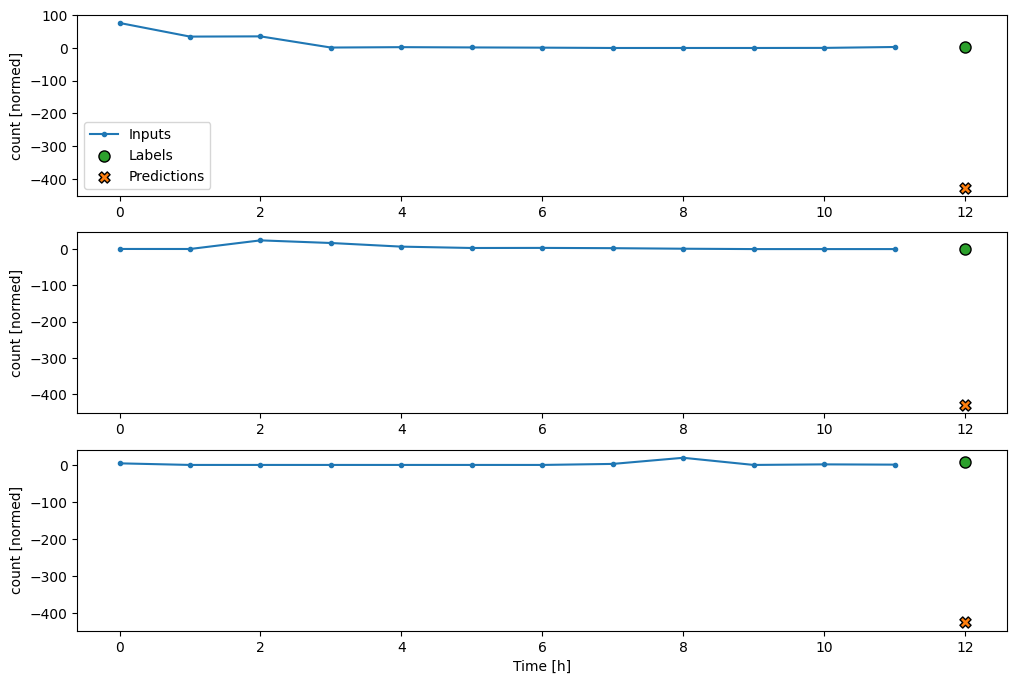

In [117]:
# Construir un modelo llamado 'lineal' con una única capa densa de una sola unidad. Usar los siguientes 
# elementos de TensorFlow:
#   - tf.keras.Sequential
#   - tf.keras.layers.Dense
lineal = tf.keras.Sequential([
    tf.keras.layers.Dense(1)  # Capa densa con una sola unidad
])

# Compilar y evaluar el modelo 'lineal' con el generador 'wg_7_1'.
# Guardar el resultado de la función 'compile_and_fit' en un objeto history
# Guardar los resultados en el DataFrame RESULTADOS con la clave 'Lineal', usando el método evaluate
# Mostrar ejemplos de predicción con el método 'plot' del generador de ventanas.

history = compile_and_fit(lineal, wg_7_1)

resultado_train = lineal.evaluate(wg_7_1.train)[-1]
resultado_val = lineal.evaluate(wg_7_1.val)[-1]
resultado_test = lineal.evaluate(wg_7_1.test)[-1]

RESULTADOS.loc['Lineal'] = (resultado_train, resultado_val, resultado_test)
wg_7_1.plot('count', model=lineal)

In [78]:
RESULTADOS

,train,validation,test
Lineal,1714.603638,1713.169189,1712.953857


In [79]:

history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

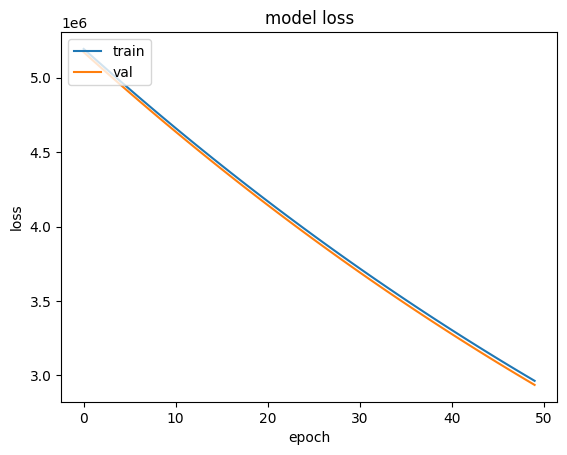

In [80]:
# curvas de aprendizaje del modelo a través de las distintas epochs,
# haciendo uso de la información contenida en el objeto history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

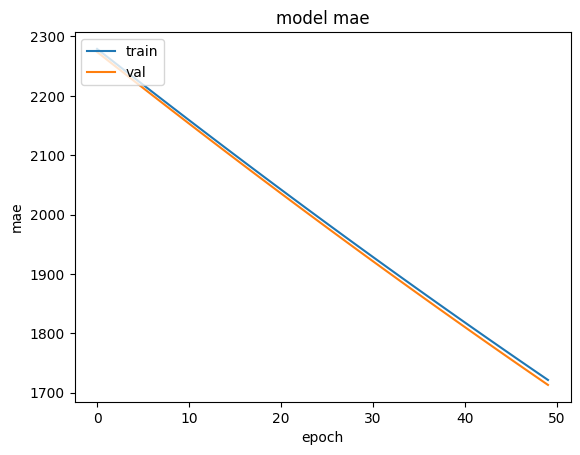

In [81]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Epoch 1/50
6/6 [==============================] - 2s 52ms/step - loss: 12569744.0000 - mean_absolute_error: 3545.2488 - val_loss: 12079318.0000 - val_mean_absolute_error: 3475.3438
Epoch 2/50
6/6 [==============================] - 0s 15ms/step - loss: 11741198.0000 - mean_absolute_error: 3426.4023 - val_loss: 11280232.0000 - val_mean_absolute_error: 3358.4155
Epoch 3/50
6/6 [==============================] - 0s 14ms/step - loss: 10963168.0000 - mean_absolute_error: 3310.9336 - val_loss: 10532832.0000 - val_mean_absolute_error: 3245.2390
Epoch 4/50
6/6 [==============================] - 0s 13ms/step - loss: 10236742.0000 - mean_absolute_error: 3199.3596 - val_loss: 9836936.0000 - val_mean_absolute_error: 3136.1919
Epoch 5/50
6/6 [==============================] - 0s 15ms/step - loss: 9561146.0000 - mean_absolute_error: 3091.9861 - val_loss: 9191056.0000 - val_mean_absolute_error: 3031.4749
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 8934591.0000 - mean_absolut

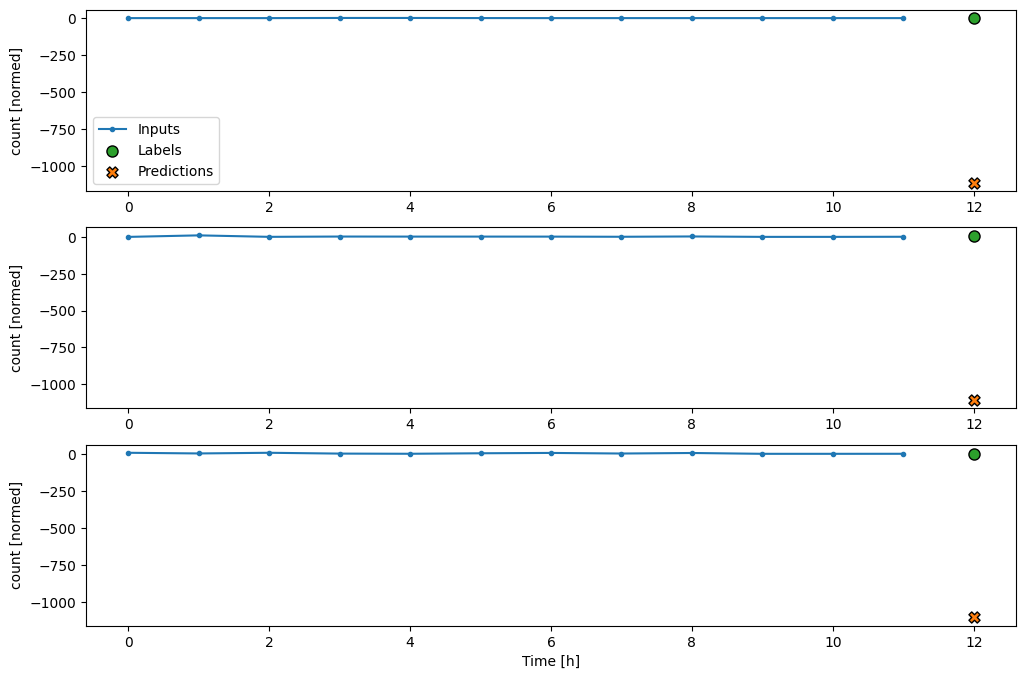

In [82]:
# construir un modelo llamado 'denso' con:
#   - Dos capas densas de 4 unidades, con función de activación ReLU
#   - Una capa densa final de una sola unidad, con función de activación lineal
# Usar los siguientes elementos de TensorFlow:
#   - tf.keras.Sequential
#   - tf.keras.layers.Dense

denso = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# compilar y evaluar el modelo 'denso' con el generador 'wg_7_1'.
# Guardar el resultado de la función 'compile_and_fit' en un objeto history
# Guardar los resultados en el DataFrame RESULTADOS con la clave 'Denso', usando el método evaluate
# Mostrar ejemplos de predicción con el método 'plot' del generador de ventanas.

history = compile_and_fit(denso, wg_7_1)

resultado_train = denso.evaluate(wg_7_1.train)[-1]
resultado_val = denso.evaluate(wg_7_1.val)[-1]
resultado_test = denso.evaluate(wg_7_1.test)[-1]

RESULTADOS.loc['Denso'] = (resultado_train, resultado_val, resultado_test)
wg_7_1.plot('count', model=denso)

In [26]:
RESULTADOS

,train,validation,test
Lineal,2.823605,14.675935,8.651300
Denso,2.838336,14.069904,6.042957


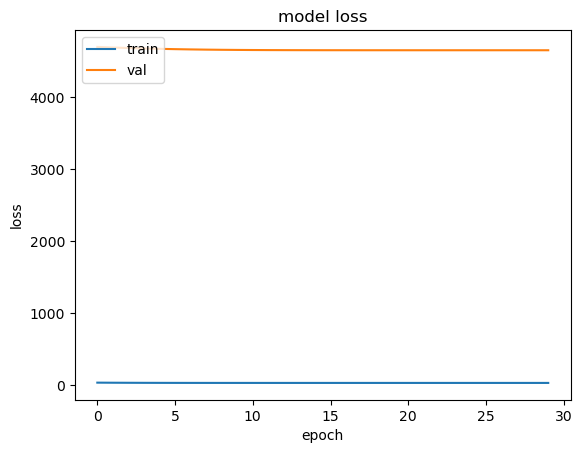

In [27]:
# Dibuja las curvas de aprendizaje del modelo a través de las distintas epochs,
# haciendo uso de la información contenida en el objeto history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Epoch 1/300
377/377 [==============================] - 7s 8ms/step - loss: 32.0890 - mean_absolute_error: 2.4331 - val_loss: 4300.1821 - val_mean_absolute_error: 13.1343
Epoch 2/300
377/377 [==============================] - 2s 6ms/step - loss: 30.6419 - mean_absolute_error: 2.7002 - val_loss: 4304.7759 - val_mean_absolute_error: 13.1001
Epoch 3/300
54/54 [==============================] - 0s 2ms/step - loss: 532.3728 - mean_absolute_error: 6.0971


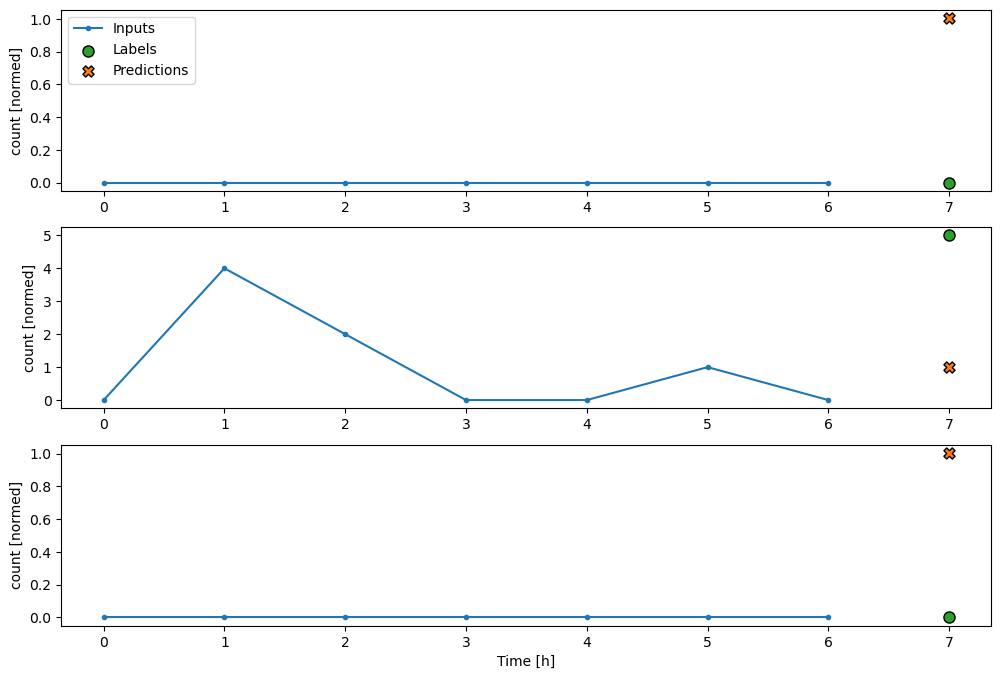

In [28]:
# Construir y evaluar un modelo llamado 'lstm' con:
#   - Dos capas LSTM con 4 unidades
#   - Una capa densa de una sola unidad
# Usar los siguientes elementos de TensorFlow:
#   - tf.keras.Sequential
#   - tf.keras.layers.Dense
#   - tf.keras.layers.LSTM

lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(4, return_sequences=True),
    tf.keras.layers.LSTM(4, return_sequences=True),
    tf.keras.layers.Dense(1)
])

# EJERCICIO: compilar y evaluar el modelo 'lstm' con el generador 'wg_7_1'.
# Guardar el resultado de la función 'compile_and_fit' en un objeto history
# Guardar los resultados en el DataFrame RESULTADOS con la clave 'LSTM', usando el método evaluate
# Mostrar ejemplos de predicción con el método 'plot' del generador de ventanas.

history = compile_and_fit(lstm, wg_7_1, max_epochs=300)

resultado_train = lstm.evaluate(wg_7_1.train)[-1]
resultado_val = lstm.evaluate(wg_7_1.val)[-1]
resultado_test = lstm.evaluate(wg_7_1.test)[-1]

RESULTADOS.loc['LSTM'] = (resultado_train, resultado_val, resultado_test)
wg_7_1.plot('count', model=lstm)

In [29]:
RESULTADOS

,train,validation,test
Lineal,2.823605,14.675935,8.651300
Denso,2.838336,14.069904,6.042957
LSTM,2.498533,13.073338,6.097133


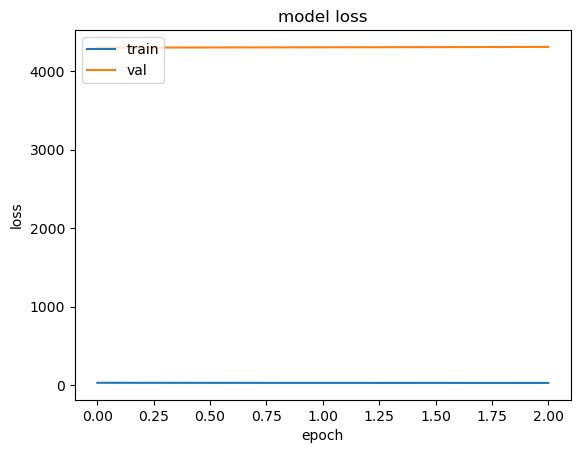

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Epoch 1/300
377/377 [==============================] - 6s 8ms/step - loss: 32.3225 - mean_absolute_error: 2.4064 - val_loss: 4296.3037 - val_mean_absolute_error: 13.1138
Epoch 2/300
377/377 [==============================] - 3s 7ms/step - loss: 31.2848 - mean_absolute_error: 2.7140 - val_loss: 4291.5566 - val_mean_absolute_error: 13.1323
Epoch 3/300
377/377 [==============================] - 2s 6ms/step - loss: 31.1164 - mean_absolute_error: 2.7567 - val_loss: 4290.1592 - val_mean_absolute_error: 13.1344
Epoch 4/300
377/377 [==============================] - 2s 6ms/step - loss: 31.0902 - mean_absolute_error: 2.7693 - val_loss: 4289.8662 - val_mean_absolute_error: 13.1323
Epoch 5/300
377/377 [==============================] - 3s 7ms/step - loss: 30.9914 - mean_absolute_error: 2.7757 - val_loss: 4289.1963 - val_mean_absolute_error: 13.1349
Epoch 6/300
377/377 [==============================] - 2s 6ms/step - loss: 30.9694 - mean_absolute_error: 2.7818 - val_loss: 4288.7510 - val_mean_abso

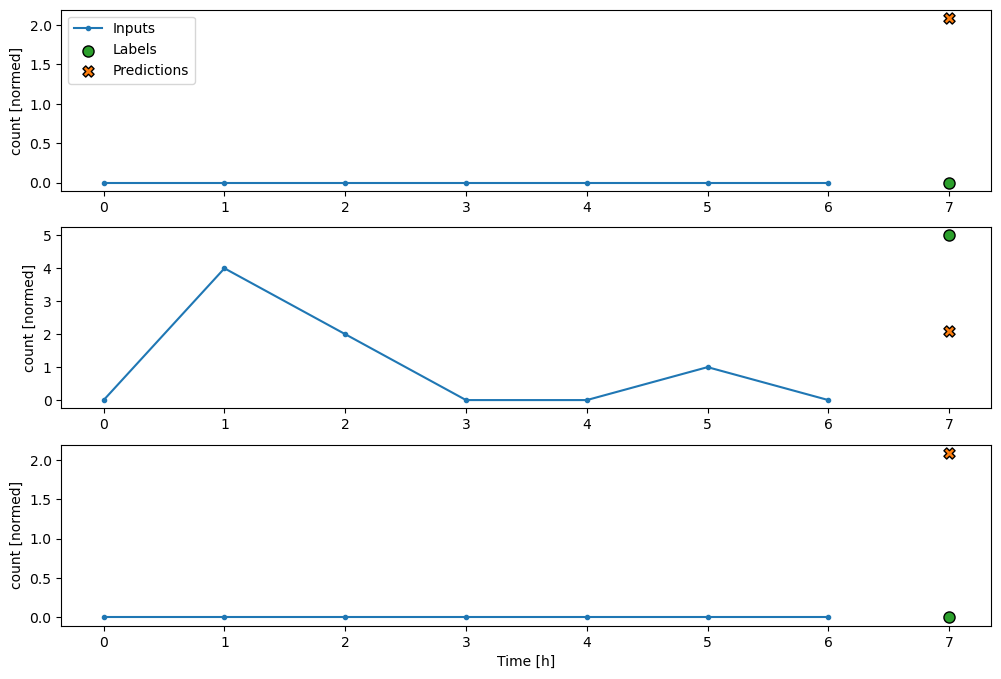

In [31]:
# construir y evaluar un modelo llamado 'lstm_dropout' con:
#   - Dos capas LSTM con 4 unidades
#   - Una capa dropout con una reducción del 20%
#   - Una capa densa de una sola unidad
# Usar los siguientes elementos de TensorFlow:
#   - tf.keras.Sequential
#   - tf.keras.layers.Dense
#   - tf.keras.layers.LSTM

lstm_dropout = tf.keras.Sequential([
    tf.keras.layers.LSTM(4, return_sequences=True),
    tf.keras.layers.LSTM(4, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

# EJERCICIO: compilar y evaluar el modelo 'lstm_dropout' con el generador 'wg_7_1'.
# Guardar el resultado de la función 'compile_and_fit' en un objeto history
# Guardar los resultados en el DataFrame RESULTADOS con la clave 'Lineal', usando el método evaluate
# Mostrar ejemplos de predicción con el método 'plot' del generador de ventanas.

history = compile_and_fit(lstm_dropout, wg_7_1, max_epochs=300)

resultado_train = lstm_dropout.evaluate(wg_7_1.train)[-1]
resultado_val = lstm_dropout.evaluate(wg_7_1.val)[-1]
resultado_test = lstm_dropout.evaluate(wg_7_1.test)[-1]

RESULTADOS.loc['LSTM-dropout'] = (resultado_train, resultado_val, resultado_test)
wg_7_1.plot('count', model=lstm_dropout)

In [32]:
RESULTADOS

,train,validation,test
Lineal,2.823605,14.675935,8.651300
Denso,2.838336,14.069904,6.042957
LSTM,2.498533,13.073338,6.097133
LSTM-dropout,2.809526,13.141443,6.012852


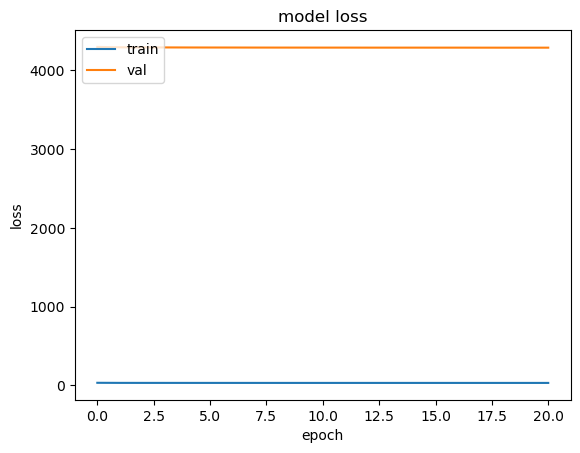

In [33]:
# Ejercicio: Dibuja las curvas de aprendizaje del modelo a través de las distintas epochs,
# haciendo uso de la información contenida en el objeto history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()